<a href="https://colab.research.google.com/github/christofkaelin/ca683-project-group-1/blob/main/CA683_Project_Group1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CA683 Project Group 1: Stock Market Price Trend Prediction
Authors: [Kevin Cogan](mailto:kevin.cogan3@mail.dcu.ie), [Paul Duhamel-Sebline](mailto:paul.duhamelsebline2@mail.dcu.ie), [Christof Kälin](mailto:christof.kalin2@mail.dcu.ie) and [Gonzalo López Gil](mailto:gonzalo.lopezgil2@mail.dcu.ie)


### Idea & Goal

Since Paul and Gonzalo are doing their [practicum](https://gitlab.computing.dcu.ie/lopezgg2/2024-mcm-lopezgg2-duhamep2) together on the prediction of stock market price trends, we decided to go with this topic.

Therefore, we went with a dataset found on Kaggle that has historical data about stocks from January 2000 until today: https://www.kaggle.com/datasets/nelgiriyewithana/world-stock-prices-daily-updating

Following this, the research question was formulated: Can we forecast the development of the S&P500 using time series models?
// TODO need to make it more precise, e.g. compare models and see which one has the highest monetary gain

### Imports

In [ ]:
# Import all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

import requests
from bs4 import BeautifulSoup

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import SimpleRNN, Dropout, Dense
from keras.optimizers import SGD

### Loading the data

In [ ]:
# Download the dataset to the Colab environment
!wget https://student.computing.dcu.ie/~kalinc2/ca683/World-Stock-Prices-Dataset.csv

In [ ]:
#Read the CSV file
df = pd.read_csv('World-Stock-Prices-Dataset.csv')

## Pre-Processing & EDA


### Data Pre-Processing

**Analyse Missing Values**

In [ ]:
# Analyzing missing values
def analyze_missing_values(dataframe):
    # Count total missing and sort it
    total = dataframe.isnull().sum().sort_values(ascending=False)

    # Calculate percentage
    percent = (dataframe.isnull().sum() / dataframe.isnull().count() * 100).sort_values(ascending=False)

    # Concatenate total and percent into a DataFrame
    missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])

    # Exclude columns that do not have any missing values
    missing_data = missing_data[missing_data['Total Missing'] > 0]

    return missing_data

# Get the missing values data
missing_values_data = analyze_missing_values(df)

print(missing_values_data)

**Parsing Dates**

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

**Numerical Correction**

In [ ]:
numerical_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
for col in numerical_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

**Handle Missing Data**

In [ ]:
df.dropna(inplace=True)

**Standardising Text**

In [ ]:
text_columns = ['Brand_Name', 'Ticker', 'Industry_Tag', 'Country']
for col in text_columns:
    df[col] = df[col].str.lower()

**Remove Whitespaces**

In [ ]:
text_columns = ['Brand_Name', 'Ticker', 'Industry_Tag', 'Country']
for col in text_columns:
    df[col] = df[col].str.strip()

### Exploratory Data Analysis

In [ ]:
# Summary statistics for numerical columns
summary_statistics = df.describe()

# Count of unique values in categorical columns
unique_brands = df['Brand_Name'].nunique()
unique_tickers = df['Ticker'].nunique()
unique_industries = df['Industry_Tag'].nunique()
unique_countries = df['Country'].nunique()

# Convert dates to datetime for any time series analysis
df['Date'] = pd.to_datetime(df['Date'], utc=True)

# Earliest and latest date in the dataset to understand the time range
earliest_date = df['Date'].min()
latest_date = df['Date'].max()

summary_statistics, unique_brands, unique_tickers, unique_industries, unique_countries, earliest_date, latest_date

### Graph Analysis

In [ ]:
# Preparing data for plotting
# Distribution of Closing Prices
closing_prices = df['Close']

# Distribution of Volumes
volumes = df['Volume']

# Dividends and Stock Splits
dividends = df['Dividends']
stock_splits = df['Stock Splits']

# Industry representation
industry_counts = df['Industry_Tag'].value_counts()

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Distribution of Closing Prices
sns.histplot(closing_prices, bins=100, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of Closing Prices')
axes[0, 0].set_xscale('log')
axes[0, 0].set_xlabel('Closing Price (Log Scale)')
axes[0, 0].set_ylabel('Frequency')

# Distribution of Volumes
sns.histplot(volumes, bins=100, ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Distribution of Trading Volumes')
axes[0, 1].set_xscale('log')
axes[0, 1].set_xlabel('Volume (Log Scale)')
axes[0, 1].set_ylabel('Frequency')

# Industry Representation
industry_counts.plot(kind='bar', ax=axes[1, 0], color='mediumpurple')
axes[1, 0].set_title('Number of Entries by Industry')
axes[1, 0].set_xlabel('Industry Tag')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Dividends and Stock Splits Presence
dividends_non_zero = dividends[dividends > 0].count()
stock_splits_non_zero = stock_splits[stock_splits > 0].count()
presence_data = {'Event': ['Dividends', 'Stock Splits'], 'Count': [dividends_non_zero, stock_splits_non_zero]}

presence_df = pd.DataFrame(presence_data)
presence_df.plot(kind='bar', x='Event', y='Count', ax=axes[1, 1], color='tomato')
axes[1, 1].set_title('Presence of Dividends and Stock Splits')
axes[1, 1].set_ylabel('Number of Non-Zero Entries')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

1. Distribution of Closing Prices: This histogram shows the frequency distribution of closing prices on a logarithmic scale, highlighting the wide range of stock prices in the dataset. The log scale helps to better visualize the distribution across a broad range of values.

2. Distribution of Trading Volumes: Similar to the closing prices, this histogram uses a logarithmic scale to display the trading volumes, illustrating the varied trading activity across different stocks. The log scale is crucial for managing the wide disparity in volumes.

3. Number of Entries by Industry: The bar chart presents the count of dataset entries categorized by industry, showcasing which sectors are more prevalent. This visualization helps identify the industries with the highest representation in the dataset.

4. Presence of Dividends and Stock Splits: This bar chart shows the number of non-zero entries for dividends and stock splits, offering insight into how often these events occur within the dataset. It highlights the relative rarity of dividends and stock splits compared to the total number of entries.

**Effect of COVID on the Stock Market**

In [ ]:
# Filtering the dataset for pre-COVID and post-COVID periods

# Assuming the dataset uses UTC time zone
pre_covid_end_date = pd.to_datetime('2020-03-01', utc=True)

# Now perform the comparison with datetime objects
pre_covid_df = df[df['Date'] < pre_covid_end_date]
post_covid_df = df[df['Date'] >= pre_covid_end_date]


# Aggregating data for each industry for pre-COVID and post-COVID periods
# Focus on average closing price and average volume as key metrics
pre_covid_agg = pre_covid_df.groupby('Industry_Tag').agg({
    'Close': 'mean',
    'Volume': 'mean'
}).reset_index().rename(columns={'Close': 'Pre-COVID Avg Close', 'Volume': 'Pre-COVID Avg Volume'})

post_covid_agg = post_covid_df.groupby('Industry_Tag').agg({
    'Close': 'mean',
    'Volume': 'mean'
}).reset_index().rename(columns={'Close': 'Post-COVID Avg Close', 'Volume': 'Post-COVID Avg Volume'})

# Merging the pre-COVID and post-COVID aggregated data for comparison
covid_impact = pd.merge(pre_covid_agg, post_covid_agg, on='Industry_Tag')

# Calculating the percentage change in average close price and volume
covid_impact['% Change in Avg Close'] = ((covid_impact['Post-COVID Avg Close'] - covid_impact['Pre-COVID Avg Close']) / covid_impact['Pre-COVID Avg Close']) * 100
covid_impact['% Change in Avg Volume'] = ((covid_impact['Post-COVID Avg Volume'] - covid_impact['Pre-COVID Avg Volume']) / covid_impact['Pre-COVID Avg Volume']) * 100

# Sorting by percentage change in average close price for visualization
covid_impact_sorted = covid_impact.sort_values(by='% Change in Avg Close', ascending=False)

covid_impact_sorted

In [ ]:
# Plotting the results
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:blue'
ax1.set_xlabel('Industry')
ax1.set_ylabel('% Change in Avg Close', color=color)
ax1.bar(covid_impact_sorted['Industry_Tag'], covid_impact_sorted['% Change in Avg Close'], color=color, label='% Change in Avg Close')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(False)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('% Change in Avg Volume', color=color)
ax2.plot(covid_impact_sorted['Industry_Tag'], covid_impact_sorted['% Change in Avg Volume'], color=color, marker='o', label='% Change in Avg Volume', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.title('COVID-19 Impact on Industries: Change in Avg Close and Volume')
plt.show()

### Feature Engineering
As we learnt about feature engineering and enriching data current columns and web scraping, we decided to evaluate which companies are in the *current* S&P 500 index fund. The source used to scrape is Wikipedia.

In [ ]:
# Get a list of companies in the S&P 500 index
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find('table', id='constituents')

company_names = []
for row in table.find_all('tr')[1:]:  # Skip header row
    cells = row.find_all('td')
    company_names.append(cells[0].text.strip().lower())

In [ ]:
# Add them to the dataframe
df['SP500'] = df['Ticker'].apply(lambda x: x in company_names)

In [ ]:
# Plot bars
plt.bar(['In S&P 500', 'Not in S&P 500'], [df['SP500'].value_counts()[True], df['SP500'].value_counts()[False]], label='Count')

# Set labels and title
plt.ylabel('Number of rows')
plt.title('Number of rows in S&P 500')

# Show plot
plt.show()

## Time Series

Out of this index we are creating a time series by summing up the Close prices from each day. \
We then derive two more times series: On a monthly and on a quarterly basis.

In [ ]:
ts = df.loc[df['SP500'] ==True].groupby('Date')['Close'].sum().reset_index()

In [ ]:
cutoff_date = pd.Timestamp('2023-07-01', tz='UTC')
ts = ts[ts['Date'] < cutoff_date] # Drop after June 2023
print(f"Max. date: {ts['Date'].max()}")

In [ ]:
# Split training and test data

splitting_date = pd.Timestamp('2022-01-01', tz='UTC')
ts_train = ts[ts['Date'] < splitting_date] # Training group until 2021
print(f"Max. date training: {ts_train['Date'].max()}")

In [ ]:
ts_test = ts[ts['Date'] >= splitting_date] # Test group from 2022
print(f"Min. date test: {ts_test['Date'].min()}")

In [ ]:
ts_train.plot.line(x='Date', y='Close');

### Prediction: Recurrent Neural Network

#### Normalization

In [ ]:
# Selecting the Close Values
rnn_train = ts_train['Close'].values
# Reshaping 1D to 2D array
rnn_train = np.reshape(rnn_train, (-1,1))
rnn_train.shape

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
rnn_train_scaled = scaler.fit_transform(rnn_train)

print(rnn_train_scaled[:5])

In [ ]:
# Repeat for test
rnn_test = ts_test['Close'].values
rnn_test = np.reshape(rnn_test, (-1,1))
rnn_test_scaled = scaler.fit_transform(rnn_test)

#### Divide into X and y and reshape

In [ ]:
X_train = []
y_train = []
for i in range(50, len(rnn_train_scaled)):
    X_train.append(rnn_train_scaled[i-50:i, 0])
    y_train.append(rnn_train_scaled[i, 0])
    if i <= 51:
        print(X_train)
        print(y_train)
        print()

In [ ]:
X_test = []
y_test = []
for i in range(50, len(rnn_test_scaled)):
    X_test.append(rnn_test_scaled[i-50:i, 0])
    y_test.append(rnn_test_scaled[i, 0])

In [ ]:
# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print('X_train:', X_train.shape, '// y_train:', y_train.shape)

In [ ]:
# The data is converted to numpy array
X_test, y_test = np.array(X_test), np.array(y_test)

#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print('X_test :', X_test.shape, '// y_test :', y_test.shape)

#### RNN model

Code from here: https://www.geeksforgeeks.org/time-series-forecasting-using-recurrent-neural-networks-rnn-in-tensorflow/

In [ ]:
"""
# Initliaze the RNN
regressor = Sequential()

# Add RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 50,
                        activation = 'tanh',
                        return_sequences = True,
                        input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50,
                        activation = 'tanh',
                        return_sequences = True))

regressor.add(SimpleRNN(units = 50,
                        activation = 'tanh',
                        return_sequences = True))

regressor.add( SimpleRNN(units = 50))

# Add output layer
regressor.add(Dense(units = 1,activation='sigmoid'))

# Comple RNN
regressor.compile(optimizer = SGD(learning_rate=0.01,
                                  momentum=0.9,
                                  nesterov=True),
                  loss = 'mean_squared_error')

# Fit the model
regressor.fit(X_train, y_train, epochs = 20, batch_size = 2)
regressor.summary()

# Save trained model
regressor.save('regressor.keras')
"""

#### Prediction

In [ ]:
# Download the trained model
!wget https://student.computing.dcu.ie/~kalinc2/ca683/regressor.keras

In [ ]:
regressor = load_model('regressor.keras')

In [ ]:
y_RNN = scaler.inverse_transform(regressor.predict(X_test))

In [ ]:
# Plot for RNN predictions
plt.figure(figsize=(18, 12))
plt.plot(ts_train.index[150:], ts_train['Close'].values[150:], label='ts_train', color='b')
plt.plot(ts_test.index, ts_test['Close'].values, label='ts_test', color='g')
plt.plot(ts_test.index[50:], y_RNN, label='y_RNN', color='brown')
plt.legend()
plt.title('Basic RNN')

plt.xlabel('Days')
plt.ylabel('Close price')

plt.show()


#### LSTM Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


**Import and Load Data**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import os
import datetime

In [ ]:
splitting_date

In [ ]:
data = ts

# Graph all data before 2021
data.plot.line(x='Date', y='Close')

# Training group until 2021
ts_train = data[data['Date'] < splitting_date]
ts_test = data[data['Date'] >= splitting_date]

# Graph each section for validation
ts_train.plot.line(x='Date', y='Close')
ts_test.plot.line(x='Date', y='Close')


close_prices = data['Close'].values.reshape(-1, 1)

In [ ]:
# Normalize the feature data
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices)

In [ ]:
# Function to create sequences from the data
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length - 1):
        seq = data[i:(i + sequence_length), 0]
        label = data[i + sequence_length, 0]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

In [ ]:
index_splitting = data[data['Date'] > splitting_date].index[0]

In [ ]:
sequence_length = 60
X, y = create_sequences(close_prices_scaled, sequence_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:index_splitting], X[index_splitting:]
y_train, y_test = y[:index_splitting], y[index_splitting:]


X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

regressor = Sequential()
regressor.add(LSTM(units=50, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, activation="tanh", return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, activation="tanh"))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='linear'))

regressor.compile(optimizer=Adam(learning_rate=0.01), loss="mean_squared_error")

In [ ]:
# Callbacks for early stopping and saving checkpoints
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# TensorBoard Callback
%load_ext tensorboard
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
%tensorboard --logdir logs

In [134]:
# Fit the model with callbacks
regressor.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[model_checkpoint_callback, early_stopping_callback, tensorboard_callback])


Epoch 1/100
156/156 [==============================] - ETA: 0s - loss: 0.0037

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


156/156 [==============================] - 25s 110ms/step - loss: 0.0037 - val_loss: 0.0087
Epoch 2/100
156/156 [==============================] - 15s 99ms/step - loss: 4.2891e-04 - val_loss: 0.0096
Epoch 3/100
156/156 [==============================] - 16s 101ms/step - loss: 3.2282e-04 - val_loss: 0.0087
Epoch 4/100
156/156 [==============================] - 17s 106ms/step - loss: 2.7060e-04 - val_loss: 0.0105
Epoch 5/100
156/156 [==============================] - 16s 100ms/step - loss: 2.8066e-04 - val_loss: 0.0122
Epoch 6/100
156/156 [==============================] - 30s 191ms/step - loss: 2.7359e-04 - val_loss: 0.0027
Epoch 7/100
156/156 [==============================] - 30s 190ms/step - loss: 2.4913e-04 - val_loss: 0.0027
Epoch 8/100
156/156 [==============================] - 23s 146ms/step - loss: 2.4209e-04 - val_loss: 0.0090
Epoch 9/100
156/156 [==============================] - 28s 181ms/step - loss: 2.3874e-04 - val_loss: 0.0102
Epoch 10/100
156/156 [=======================

In [135]:
# Summary of the model
regressor.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [138]:
regressor = load_model('model_checkpoint.h5')

10/10 [==============================] - 2s 36ms/step


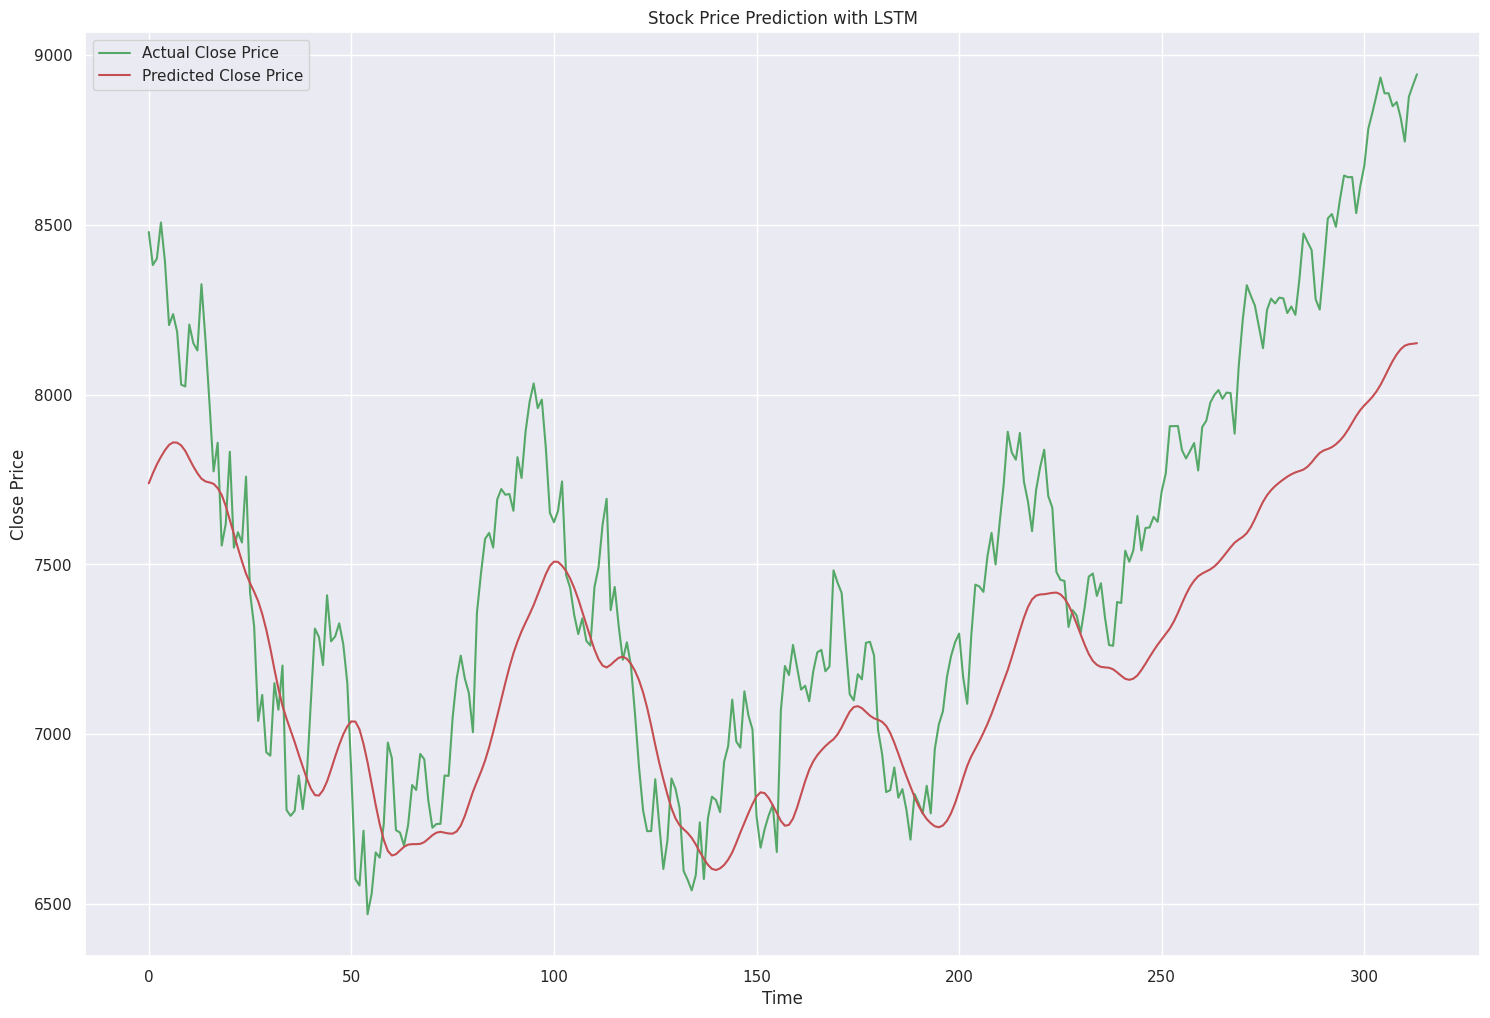

In [139]:
import matplotlib.pyplot as plt

# Assuming X_test is your test dataset prepared in the previous steps
# Make predictions on the test set
y_pred_scaled = regressor.predict(X_test)

# Inverse transform the predictions to get actual values
y_pred = scaler.inverse_transform(y_pred_scaled)

# Since y_test is normalized, we also need to inverse transform it to compare accurately
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting
plt.figure(figsize=(18, 12))

# Assuming you have a pandas DataFrame with the original stock prices. You'll need to adjust indexing
# Plot actual close prices from the test set
plt.plot(y_test_actual, label='Actual Close Price', color='g')

# Plot predicted close prices
plt.plot(y_pred, label='Predicted Close Price', color='r')

plt.legend()
plt.title('Stock Price Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('Close Price')

plt.show()


10/10 [==============================] - 0s 24ms/step


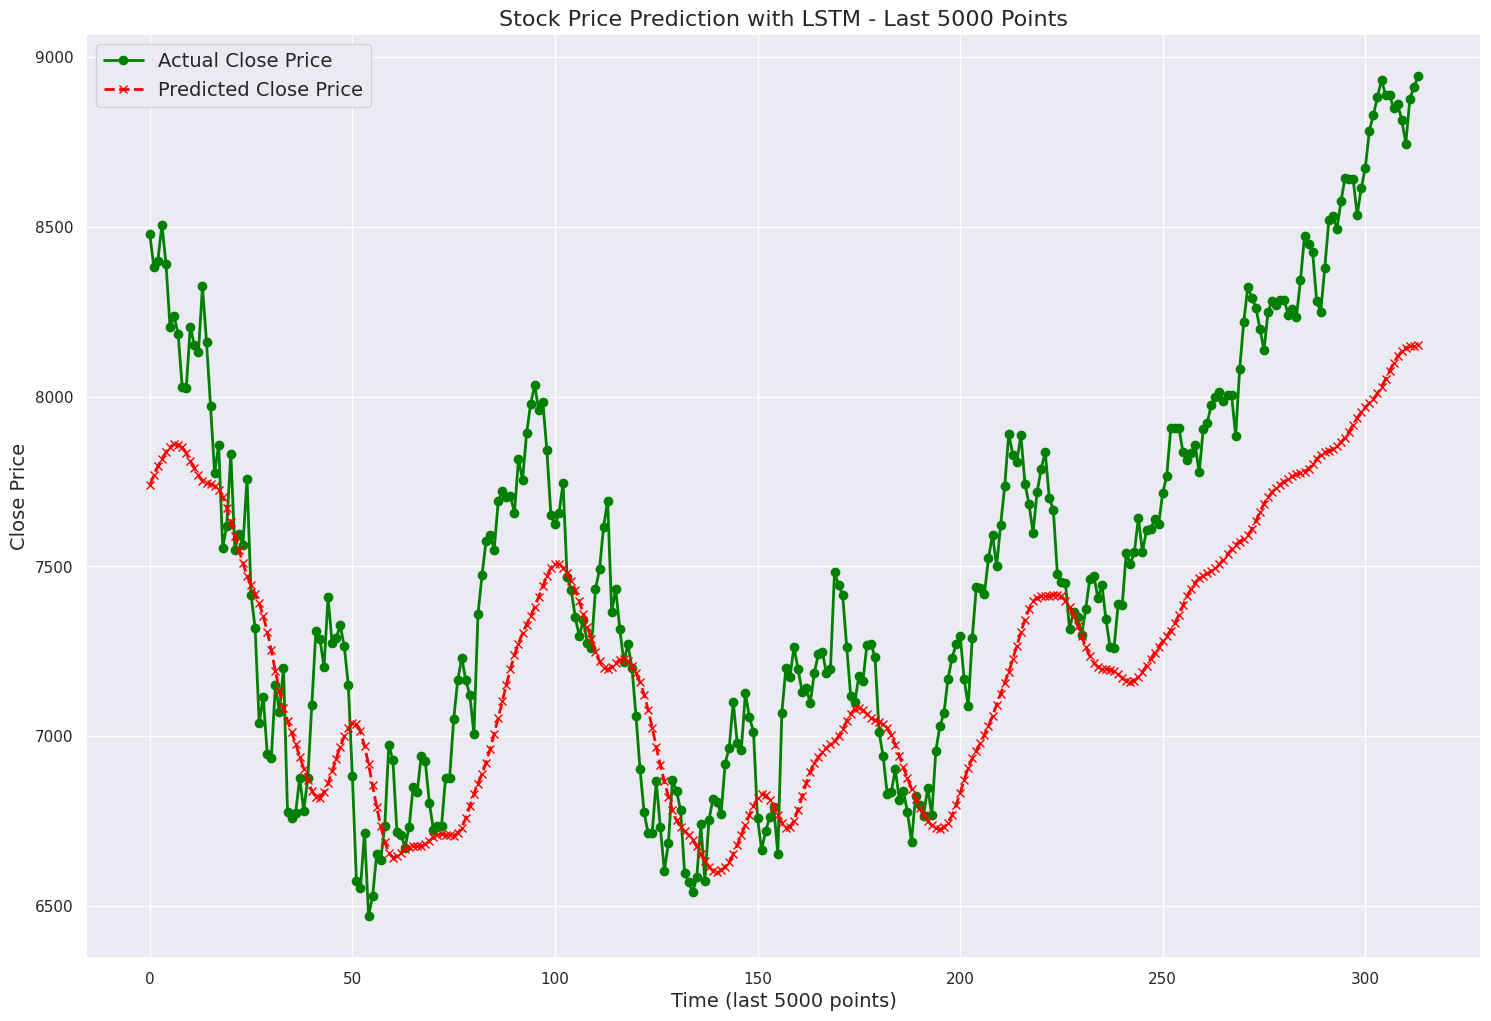

In [140]:
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_scaled = regressor.predict(X_test)

# Inverse transform the predictions to get actual values
y_pred = scaler.inverse_transform(y_pred_scaled)

# Inverse transform the actual test set values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Select a subset for a clearer view (e.g., the last 100 points)
subset_size = 5000
y_test_subset = y_test_actual[-subset_size:]
y_pred_subset = y_pred[-subset_size:]

# Plotting
plt.figure(figsize=(18, 12))

# Plot actual close prices
plt.plot(y_test_subset, marker='o', linestyle='-', linewidth=2, label='Actual Close Price', color='green')

# Plot predicted close prices
plt.plot(y_pred_subset, marker='x', linestyle='--', linewidth=2, label='Predicted Close Price', color='red')

plt.legend(fontsize=14)
plt.title(f'Stock Price Prediction with LSTM - Last {subset_size} Points', fontsize=16)
plt.xlabel(f'Time (last {subset_size} points)', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.grid(True)

plt.show()


### Statistical Models

#### Auto ARIMA

In [147]:
!pip install pmdarima

In [149]:
import pmdarima as pm

In [151]:
# Selecting the Close Values
arima_train = ts_train['Close'].values
arima_test = ts_test['Close'].values

In [153]:
#Auto-fit of the ARIMA model
auto_arima = pm.auto_arima(arima_train, seasonal=False)
auto_arima

ARIMA(order=(5, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [155]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5536
Model:               SARIMAX(5, 2, 0)   Log Likelihood              -27802.751
Date:                Mon, 25 Mar 2024   AIC                          55617.503
Time:                        21:54:25   BIC                          55657.215
Sample:                             0   HQIC                         55631.350
                               - 5536                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9350      0.004   -235.963      0.000      -0.943      -0.927
ar.L2         -0.6296      0.006   -104.810      0.000      -0.641      -0.618
ar.L3         -0.4253      0.007    -62.816      0.000      -0.439      -0.412
ar.L4         -0.3010      0.006    -47.938      0.000      -0.313      -0.289
ar.L5         -0.1037      0.004    -26.251      0.000      -0.111      -0.096
sigma2      1353.8467      6.932    195.306      0.000    1340.260    1367.433
===================================================================================
Ljung-Box (L1) (Q):                   3.56   Jarque-Bera (JB):            211080.05
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):              83.46   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [157]:
x_arima=[]
for i in range(len(arima_train)+len(arima_test)):
  x_arima.append(i)

In [159]:
forecast_arima_auto = auto_arima.predict(n_periods=len(arima_test))

Text(0, 0.5, 'Close Price')

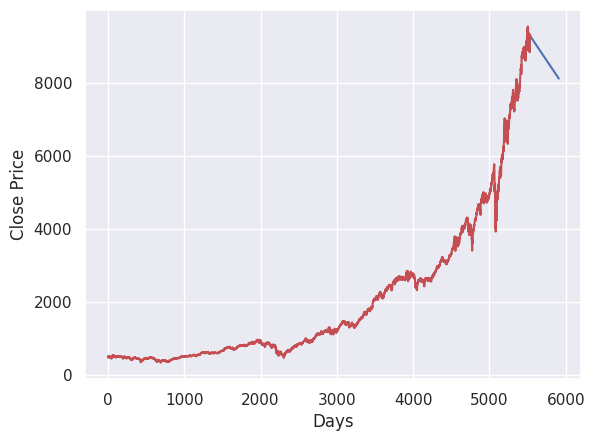

In [161]:
plt.plot(x_arima, [None]*len(arima_train) + list(forecast_arima_auto), label='ARIMA', color='b')
plt.plot(arima_train, label='historical data', color='r')

plt.xlabel('Days')
plt.ylabel('Close Price')

#### Manual ARIMA

In [163]:
#Test for stationarity (p-value > 0.05 => non-stationary)
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(arima_train)
print(adf_test)
print(f'p-value: {adf_test[1]}')

(5.623602742106369, 1.0, 31, 5504, {'1%': -3.4315386541431767, '5%': -2.8620652671839455, '10%': -2.5670495985385364}, 54075.66586862693)
p-value: 1.0


<Axes: >

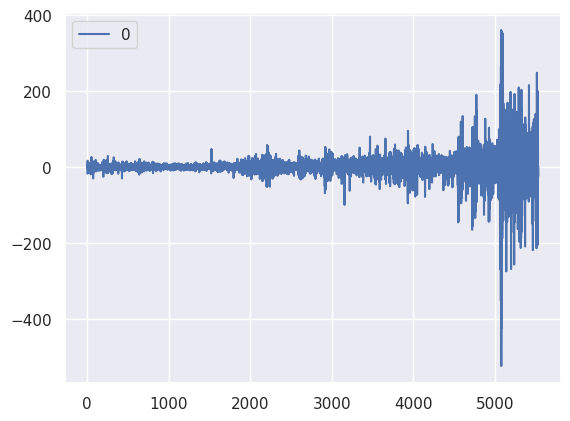

In [165]:
# Differentiate the time-series
df_train = pd.DataFrame(arima_train)
arima_train_diff = df_train.diff().dropna()
arima_train_diff.plot()

In [167]:
#Check for stationarity again
adf_test = adfuller(arima_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 4.7352564262924274e-27


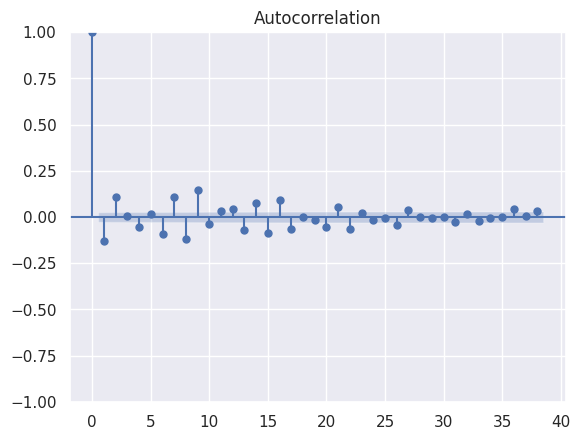

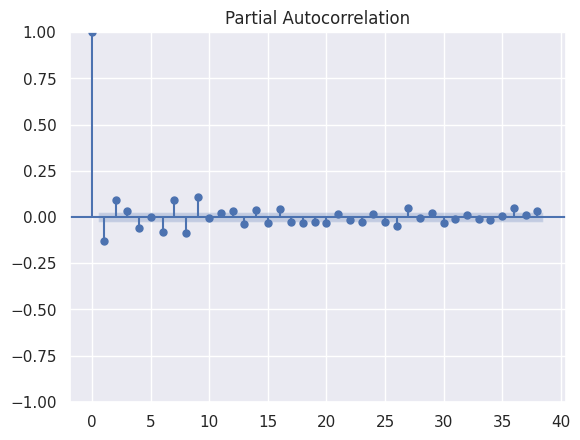

In [169]:
#Determining other parameters (p,q)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_diff = plot_acf(arima_train_diff)
pacf_diff = plot_pacf(arima_train_diff)

In [171]:
#Create the model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(arima_train, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5536
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -27338.981
Date:                Mon, 25 Mar 2024   AIC                          54683.962
Time:                        21:54:39   BIC                          54703.818
Sample:                             0   HQIC                         54690.885
                               - 5536                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1156      0.004    -30.747      0.000      -0.123      -0.108
ar.L2          0.0966      0.003     27.655      0.000       0.090       0.103
sigma2      1142.5489      5.273    216.684      0.0

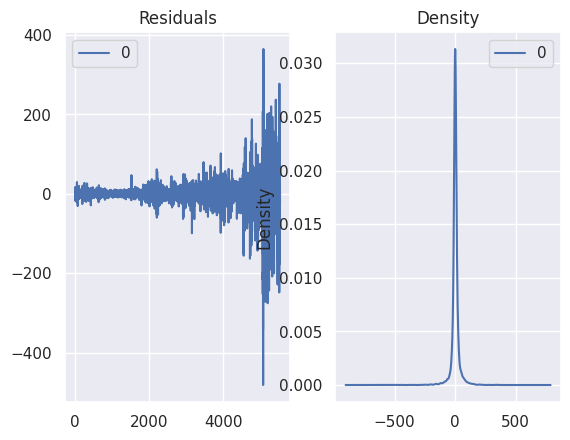

In [173]:
#Check residuals to see if model really fits
residuals = model_fit.resid[1:]
df_residuals = pd.DataFrame(residuals)
fig, ax =plt.subplots(1,2)
df_residuals.plot(title='Residuals', ax=ax[0])
df_residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

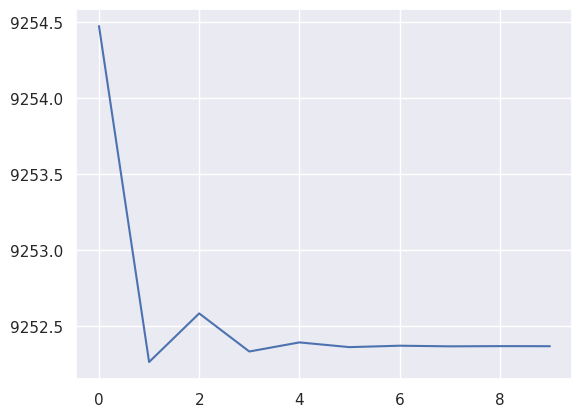

In [175]:
forecast_manual_arima = model_fit.forecast(len(arima_test))
plt.plot(forecast_manual_arima[:10])

To be continued

### Indicators

References:

[1] **Python Trading Guide: MACD** https://blog.stackademic.com/python-trading-guide-macd-b4aa256f9bed

[2] **Python Trading Guide: Leveraging RSI** https://python.plainenglish.io/python-trading-guide-leveraging-rsi-9b44ac0c66de

[3] **Python Trading Guide: Bollinger Bands** https://towardsdev.com/python-trading-guide-bollinger-bands-111ccc318bdc

[4] **A new moving average approach to predict the direction of stock movements in algorithmic trading** https://doi.org/10.54187/jnrs.979836

In [737]:
!pip install ta

In [738]:
import ta
from scipy.signal import argrelextrema

In [739]:
data = ts_train.copy()

In [740]:
data.set_index('Date', inplace=True)
data.head()

,Close
Date,
2000-01-03 05:00:00+00:00,498.219747
2000-01-04 05:00:00+00:00,481.182182
2000-01-05 05:00:00+00:00,483.862396
2000-01-06 05:00:00+00:00,488.833733
2000-01-07 05:00:00+00:00,505.682613


#### MACD

In [741]:
ta.trend.MACD.__init__

<function ta.trend.MACD.__init__(self, close: pandas.core.series.Series, window_slow: int = 26, window_fast: int = 12, window_sign: int = 9, fillna: bool = False)>

In [742]:
def calculate_macd(data):
  macd_object = ta.trend.MACD(data['Close'])
  data['MACD'] = macd_object.macd()
  data['MACD_Signal'] = macd_object.macd_signal()
  data['MACD_Diff'] = macd_object.macd_diff()
  return data

In [743]:
def plot_macd(data):
  # Plotting
  plt.figure(figsize=(14, 7))

  # Plotting Close Price
  plt.subplot(2, 1, 1)
  plt.plot(data['Close'], label='Close Price')
  plt.title('S&P500 Price and MACD')
  plt.legend()

  # Plotting MACD
  plt.subplot(2, 1, 2)
  plt.plot(data['MACD'], label='MACD Line', color='blue')
  plt.plot(data['MACD_Signal'], label='Signal Line', color='red')
  plt.bar(data.index, data['MACD_Diff'], label='Histogram', color='grey', alpha=0.5)
  plt.legend()

  plt.show()

In [744]:
data = calculate_macd(data)
data.tail()

,Close,MACD,MACD_Signal,MACD_Diff
Date,,,,
2021-12-27 05:00:00+00:00,9321.816479,-19.538400,-40.739672,21.201272
2021-12-28 05:00:00+00:00,9293.714481,-4.483296,-33.488397,29.005100
2021-12-29 05:00:00+00:00,9295.499088,7.505466,-25.289624,32.795090
2021-12-30 05:00:00+00:00,9275.912769,15.250397,-17.181620,32.432017
2021-12-31 05:00:00+00:00,9253.810799,19.381450,-9.869006,29.250456


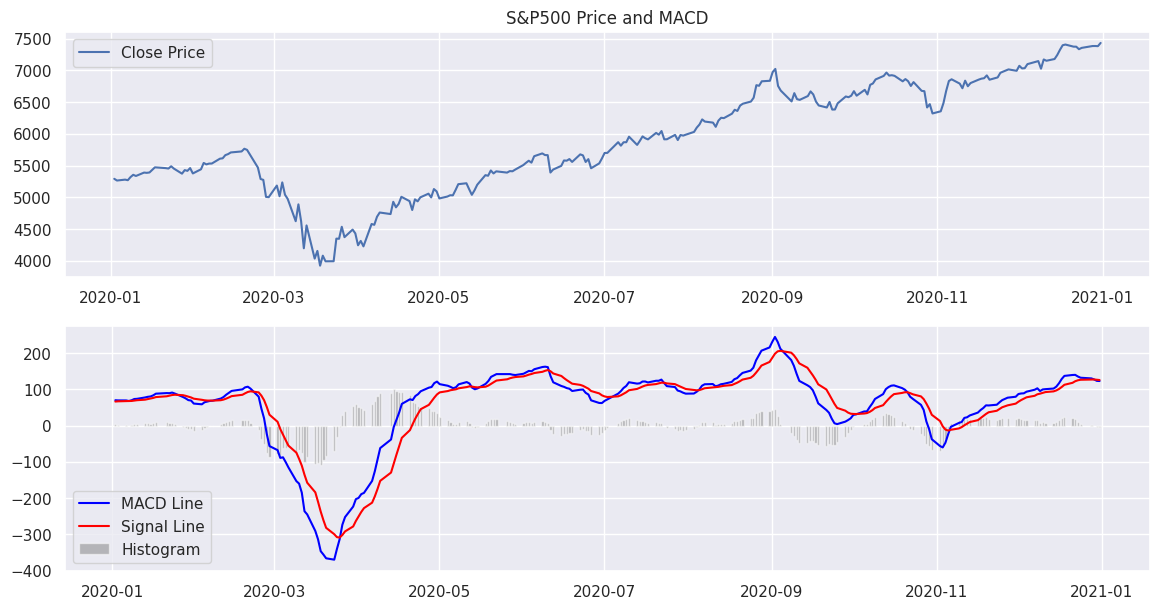

In [745]:
plot_macd(data.loc['2020-01-01':'2020-12-31']) # Plot 2020 data

#### Leveraging RSI

In [746]:
ta.momentum.RSIIndicator.__init__

<function ta.momentum.RSIIndicator.__init__(self, close: pandas.core.series.Series, window: int = 14, fillna: bool = False)>

In [747]:
def calculate_rsi(data):
  data['RSI'] = ta.momentum.RSIIndicator(data['Close']).rsi()
  return data

In [748]:
def plot_rsi(data):
  upper_limit = 70
  lower_limit = 30

  plt.figure(figsize=(10, 6))
  plt.plot(data.index, data['RSI'])
  plt.axhline(y=upper_limit, color='r', linestyle='--', label='Overbought (70)')
  plt.axhline(y=lower_limit, color='g', linestyle='--', label='Oversold (30)')
  plt.title('RSI of S&P500')
  plt.xlabel('Date')
  plt.ylabel('RSI')
  plt.legend()
  plt.grid(True)
  plt.show()

In [749]:
data = calculate_rsi(data)
data.tail()

,Close,MACD,MACD_Signal,MACD_Diff,RSI
Date,,,,,
2021-12-27 05:00:00+00:00,9321.816479,-19.538400,-40.739672,21.201272,56.193125
2021-12-28 05:00:00+00:00,9293.714481,-4.483296,-33.488397,29.005100,55.117365
2021-12-29 05:00:00+00:00,9295.499088,7.505466,-25.289624,32.795090,55.176051
2021-12-30 05:00:00+00:00,9275.912769,15.250397,-17.181620,32.432017,54.336323
2021-12-31 05:00:00+00:00,9253.810799,19.381450,-9.869006,29.250456,53.349629


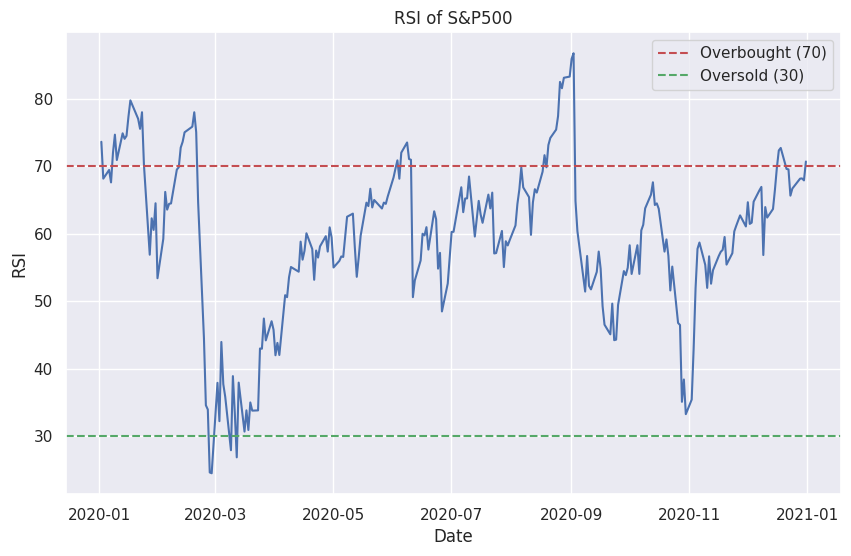

In [750]:
plot_rsi(data.loc['2020-01-01':'2020-12-31'])

#### Bollinger Bands (BB)

In [751]:
ta.volatility.BollingerBands.__init__

<function ta.volatility.BollingerBands.__init__(self, close: pandas.core.series.Series, window: int = 20, window_dev: int = 2, fillna: bool = False)>

In [752]:
def calculate_bb(data):
  indicator_bb = ta.volatility.BollingerBands(close=data["Close"], window=20, window_dev=2)
  data['bb_bbm'] = indicator_bb.bollinger_mavg()   # Middle Band
  data['bb_bbh'] = indicator_bb.bollinger_hband()  # Upper Band
  data['bb_bbl'] = indicator_bb.bollinger_lband()  # Lower Band
  return data

In [753]:
def plot_bb(data):
  plt.figure(figsize=(14,7))
  plt.plot(data['Close'], label='S&P500 Prices', color='blue')
  plt.plot(data['bb_bbh'], label='Upper Band', color='red')
  plt.plot(data['bb_bbm'], label='Middle Band (SMA)', color='green')
  plt.plot(data['bb_bbl'], label='Lower Band', color='red')
  plt.title('Bollinger Bands for S&P500')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.grid(True)
  plt.show()

In [754]:
data = calculate_bb(data)
data.tail()

,Close,MACD,MACD_Signal,MACD_Diff,RSI,bb_bbm,bb_bbh,bb_bbl
Date,,,,,,,,
2021-12-27 05:00:00+00:00,9321.816479,-19.538400,-40.739672,21.201272,56.193125,9095.605669,9398.302172,8792.909166
2021-12-28 05:00:00+00:00,9293.714481,-4.483296,-33.488397,29.005100,55.117365,9095.515089,9397.973229,8793.056949
2021-12-29 05:00:00+00:00,9295.499088,7.505466,-25.289624,32.795090,55.176051,9105.525059,9420.292972,8790.757146
2021-12-30 05:00:00+00:00,9275.912769,15.250397,-17.181620,32.432017,54.336323,9125.220288,9430.738973,8819.701604
2021-12-31 05:00:00+00:00,9253.810799,19.381450,-9.869006,29.250456,53.349629,9137.108889,9443.212295,8831.005483


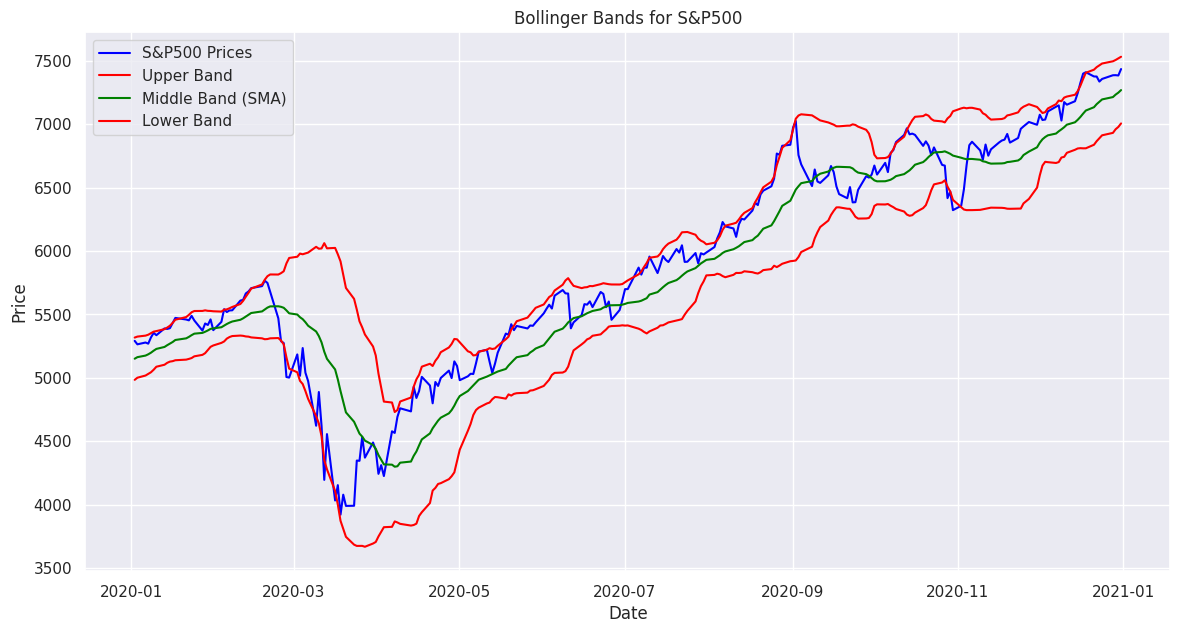

In [755]:
plot_bb(data.loc['2020-01-01':'2020-12-31'])

#### Support and Resistance (SR)

In [756]:
def calculate_sr(data):
  # Swing Trading (Medium-Term):

  # Time Horizon: Days to weeks
  # Volatility: Moderate
  # Indicator Sensitivity: Moderate
  # Data Frequency: Daily
  # Recommended Window Size: 20 to 50 data points
  WINDOW = 20 # Recommended value for Swing Trading (Medium-Term)

  data['min'] = data.iloc[argrelextrema(data['Close'].values, np.less_equal, order=WINDOW)[0]]['Close']
  data['max'] = data.iloc[argrelextrema(data['Close'].values, np.greater_equal, order=WINDOW)[0]]['Close']
  return data

In [757]:
def plot_sr(data):
  plt.figure(figsize=(15, 8))
  plt.plot(data.index, data['Close'], label='Price')
  plt.scatter(data.index, data['min'], color='green', label='Support', marker='^', alpha=0.7)
  plt.scatter(data.index, data['max'], color='red', label='Resistance', marker='v', alpha=0.7)
  plt.title('Support and Resistance Levels')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.show()

In [758]:
data = calculate_sr(data)
data.tail()

,Close,MACD,MACD_Signal,MACD_Diff,RSI,bb_bbm,bb_bbh,bb_bbl,min,max
Date,,,,,,,,,,
2021-12-27 05:00:00+00:00,9321.816479,-19.538400,-40.739672,21.201272,56.193125,9095.605669,9398.302172,8792.909166,NaN,9321.816479
2021-12-28 05:00:00+00:00,9293.714481,-4.483296,-33.488397,29.005100,55.117365,9095.515089,9397.973229,8793.056949,NaN,NaN
2021-12-29 05:00:00+00:00,9295.499088,7.505466,-25.289624,32.795090,55.176051,9105.525059,9420.292972,8790.757146,NaN,NaN
2021-12-30 05:00:00+00:00,9275.912769,15.250397,-17.181620,32.432017,54.336323,9125.220288,9430.738973,8819.701604,NaN,NaN
2021-12-31 05:00:00+00:00,9253.810799,19.381450,-9.869006,29.250456,53.349629,9137.108889,9443.212295,8831.005483,NaN,NaN


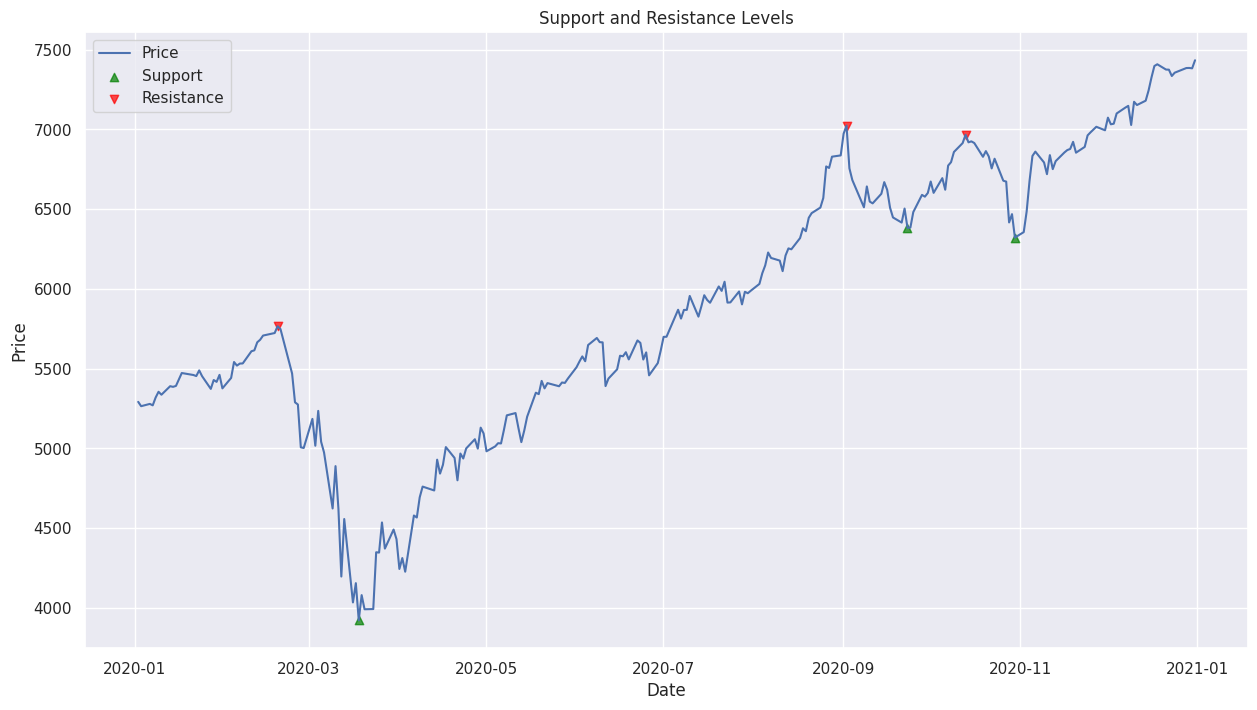

In [759]:
plot_sr(data.loc['2020-01-01':'2020-12-31'])

#### Generate Buy and Sell signals

In [760]:
def trade_with_indicator(data, initial_capital, indicator):
    current_capital = initial_capital
    is_holding = False
    shares_to_buy = 0
    gross_profits = 0
    gross_losses = 0
    daily_capital = [initial_capital]

    for i in range(1, len(data)):
        current_price = data['Close'][i]

        if indicator == 'RSI':
            current_indicator_value = data['RSI'][i]
            oversold_limit = 30
            overbought_limit = 70
            buy_condition = current_indicator_value < oversold_limit and not is_holding
            sell_condition = current_indicator_value > overbought_limit and is_holding

        elif indicator == 'BB':
            lower_band = data['bb_bbl'][i]
            upper_band = data['bb_bbh'][i]
            buy_condition = current_price < lower_band and not is_holding
            sell_condition = current_price > upper_band and is_holding

        elif indicator == 'MACD':
            macd = data['MACD'][i]
            macd_signal = data['MACD_Signal'][i]
            buy_condition = macd > macd_signal and not is_holding
            sell_condition = macd < macd_signal and is_holding

        elif indicator == 'SR':  # Support and Resistance
            support = data['min'][i] if 'min' in data.columns else None
            resistance = data['max'][i] if 'max' in data.columns else None
            buy_condition = support is not None and current_price <= support * 1.01 and not is_holding
            sell_condition = resistance is not None and current_price >= resistance * 0.99 and is_holding

        else:
            raise ValueError("Invalid indicator specified.")

        if buy_condition:
            shares_to_buy = current_capital / current_price
            buy_price = current_price  # Store the price at which the shares are bought
            current_capital = 0
            is_holding = True
            print(f"Buy {shares_to_buy} shares at {current_price} using {indicator}")

        elif sell_condition:
            sell_price = current_price  # The price at which the shares are sold
            current_capital = sell_price * shares_to_buy
            profit_or_loss = (sell_price - buy_price) * shares_to_buy
            if profit_or_loss > 0:
              gross_profits += profit_or_loss
            else:
              gross_losses += abs(profit_or_loss)
            is_holding = False
            print(f"Sell {shares_to_buy} shares at {current_price} using {indicator}. Current capital: {current_capital}")

        # Record the capital for the day, whether a trade was made or not
        daily_capital.append(current_capital if not is_holding else current_price * shares_to_buy)

    if is_holding:
        current_price = data['Close'][-1]
        sell_price = current_price
        final_capital =  sell_price * shares_to_buy
        unrealized_profit_or_loss = (sell_price - buy_price) * shares_to_buy
        if unrealized_profit_or_loss > 0:
            gross_profits += unrealized_profit_or_loss
        else:
            gross_losses += abs(unrealized_profit_or_loss)

        # Adjust the final value if holding shares at the end, don't append a new value
        daily_capital[-1] = current_price * shares_to_buy

        print(f"Final capital (holding shares) using {indicator}: ${final_capital}")
    else:
        final_capital = current_capital
        print(f"Final capital using {indicator}: ${final_capital}")

    # Calculate Profit Factor
    if gross_losses == 0:
        pf = float('inf')  # Infinite profit factor as there are no losses
    else:
        pf = gross_profits / gross_losses

    print(f"Profit Factor using {indicator}: {pf}")

    # Ensure the length of daily_capital matches the data, excluding the initial capital entry
    assert len(daily_capital) == len(data), "The daily capital list length must match the data length."

    capital_df = pd.DataFrame(daily_capital, index=data.index[:len(daily_capital)], columns=['Capital'])

    return final_capital, pf, capital_df

#### Experiment with Predicted Data

In [761]:
data_test = ts_test.copy()
data_test.set_index('Date', inplace=True)

In [762]:
days_predicted = len(y_pred)
print(f'Number of days predicted: {days_predicted}')

Number of days predicted: 314


In [763]:
values_delay = sequence_length
print(f'Sequence length defined in the LSTM model: {values_delay}')

Sequence length defined in the LSTM model: 60


In [764]:
data_test = data_test[values_delay:values_delay+days_predicted]
data_test

,Close
Date,
2022-03-30 04:00:00+00:00,8479.590611
2022-03-31 04:00:00+00:00,8382.190907
2022-04-01 04:00:00+00:00,8401.342514
2022-04-04 04:00:00+00:00,8507.580315
2022-04-05 04:00:00+00:00,8391.359867
...,...
2023-06-23 04:00:00+00:00,8815.277851
2023-06-26 04:00:00+00:00,8746.143059
2023-06-27 04:00:00+00:00,8878.032730


In [765]:
data_predicted = data_test.copy()
data_predicted['Close'] = y_pred
data_predicted

,Close
Date,
2022-03-30 04:00:00+00:00,7739.036621
2022-03-31 04:00:00+00:00,7768.472656
2022-04-01 04:00:00+00:00,7794.962402
2022-04-04 04:00:00+00:00,7817.159668
2022-04-05 04:00:00+00:00,7836.779297
...,...
2023-06-23 04:00:00+00:00,8134.375488
2023-06-26 04:00:00+00:00,8144.630859
2023-06-27 04:00:00+00:00,8148.877930


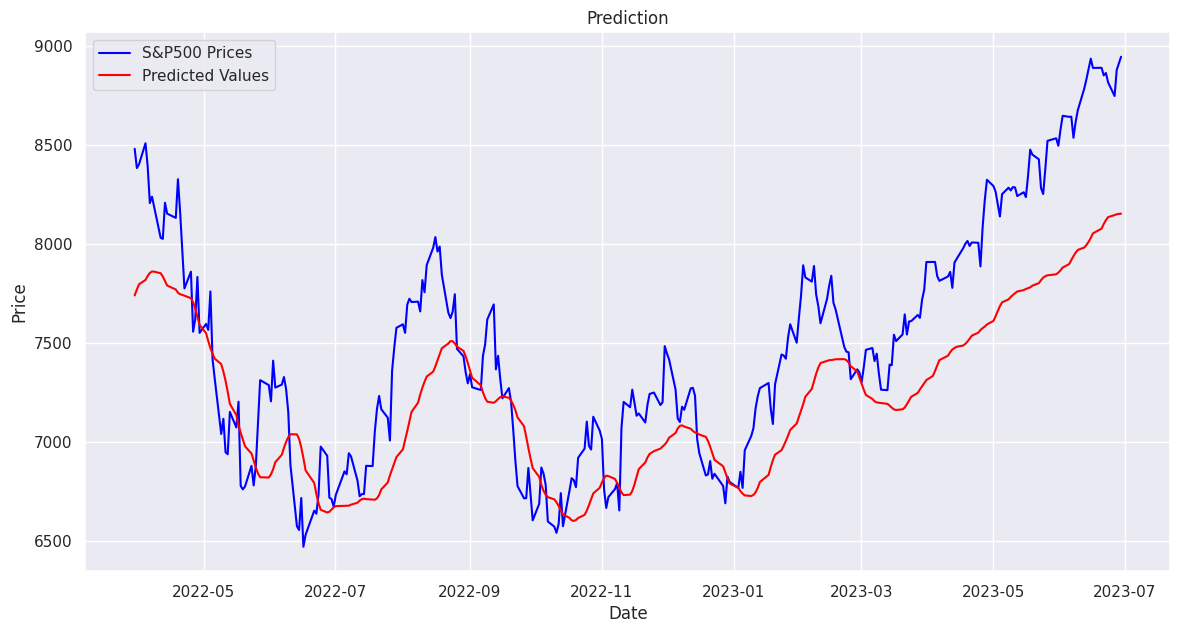

In [766]:
plt.figure(figsize=(14,7))
plt.plot(data_test['Close'], label='S&P500 Prices', color='blue')
plt.plot(data_predicted['Close'], label='Predicted Values', color='red')
plt.title('Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [767]:
start_date, end_date = '2022-05-17', '2022-11-17'

In [768]:
sample_pred = data_predicted.loc[start_date:end_date].copy()
sample_test = data_test.loc[start_date:end_date].copy()

In [769]:
initial_capital = 100000

MACD

In [770]:
sample_pred = calculate_macd(sample_pred)
sample_test = calculate_macd(sample_test)

In [771]:
capital_pred_macd, _, _ = trade_with_indicator(sample_pred, initial_capital, 'MACD')

Buy 14.966183951208487 shares at 6681.72998046875 using MACD
Sell 14.966183951208487 shares at 7458.431640625 using MACD. Current capital: 111624.25992110746
Buy 16.87591302067677 shares at 6614.4130859375 using MACD
Final capital (holding shares) using MACD: $115140.00371875195
Profit Factor using MACD: inf


In [772]:
capital_test_macd, _, _ = trade_with_indicator(sample_test, initial_capital, 'MACD')

Buy 14.629689309909155 shares at 6835.415153503418 using MACD
Sell 14.629689309909155 shares at 7651.778533935547 using MACD. Current capital: 111943.14261970922
Buy 16.60904574100148 shares at 6739.890079498291 using MACD
Sell 16.60904574100148 shares at 6720.331806182861 using MACD. Current capital: 111618.29836359824
Buy 15.789687517007232 shares at 7069.063161849976 using MACD
Final capital (holding shares) using MACD: $112598.32059412384
Profit Factor using MACD: 39.78264847576597


Leveraging RSI

In [773]:
sample_pred = calculate_rsi(sample_pred)
sample_test = calculate_rsi(sample_test)

In [774]:
capital_pred_rsi, _, _ = trade_with_indicator(sample_pred, initial_capital, 'RSI')

Buy 14.724332174606998 shares at 6791.4794921875 using RSI
Sell 14.724332174606998 shares at 6889.32470703125 using RSI. Current capital: 101440.70544505517
Buy 14.33239240552033 shares at 7077.72314453125 using RSI
Final capital (holding shares) using RSI: $97786.21831294817
Profit Factor using RSI: 0.3942291744298807


In [775]:
capital_test_rsi, _, _ = trade_with_indicator(sample_test, initial_capital, 'RSI')

Buy 15.258167610719175 shares at 6553.86692237854 using RSI
Sell 15.258167610719175 shares at 7691.6136684417725 using RSI. Current capital: 117359.93054998315
Buy 17.32219625949619 shares at 6775.118396759033 using RSI
Final capital (holding shares) using RSI: $123526.84026965292
Profit Factor using RSI: inf


BB

In [776]:
sample_pred = calculate_bb(sample_pred)
sample_test = calculate_bb(sample_test)

In [777]:
capital_pred_bb, _, _ = trade_with_indicator(sample_pred, initial_capital, 'BB')

Buy 14.951817985562297 shares at 6688.14990234375 using BB
Sell 14.951817985562297 shares at 6758.84912109375 using BB. Current capital: 101057.08185047146
Buy 13.995704120524497 shares at 7220.57861328125 using BB
Sell 13.995704120524497 shares at 6816.578125 using BB. Current capital: 95402.81055193965
Final capital using BB: $95402.81055193965
Profit Factor using BB: 0.18695279986758637


In [778]:
capital_test_bb, _, _ = trade_with_indicator(sample_test, initial_capital, 'BB')

Buy 13.603614390006923 shares at 7350.987548828125 using BB
Sell 13.603614390006923 shares at 7101.576999664307 using BB. Current capital: 96607.11506437555
Final capital using BB: $96607.11506437555
Profit Factor using BB: 0.0


SR

In [779]:
sample_pred = calculate_sr(sample_pred)
sample_test = calculate_sr(sample_test)

In [780]:
capital_pred_sr, _, _ = trade_with_indicator(sample_pred, initial_capital, 'SR')

Buy 15.054950200679986 shares at 6642.33349609375 using SR
Sell 15.054950200679986 shares at 7508.31640625 using SR. Current capital: 113037.32958704227
Buy 17.12796167918381 shares at 6599.57861328125 using SR
Sell 17.12796167918381 shares at 6828.48974609375 using SR. Current capital: 116958.11069779332
Final capital using SR: $116958.11069779332
Profit Factor using SR: inf


In [781]:
capital_test_sr, _, _ = trade_with_indicator(sample_test, initial_capital, 'SR')

Buy 15.457835114106082 shares at 6469.211196899414 using SR
Sell 15.457835114106082 shares at 8033.390975952148 using SR. Current capital: 124178.83311341605
Buy 18.988962963649954 shares at 6539.5268478393555 using SR
Sell 18.988962963649954 shares at 7262.744583129883 using SR. Current capital: 137911.98790350265
Final capital using SR: $137911.98790350265
Profit Factor using SR: inf


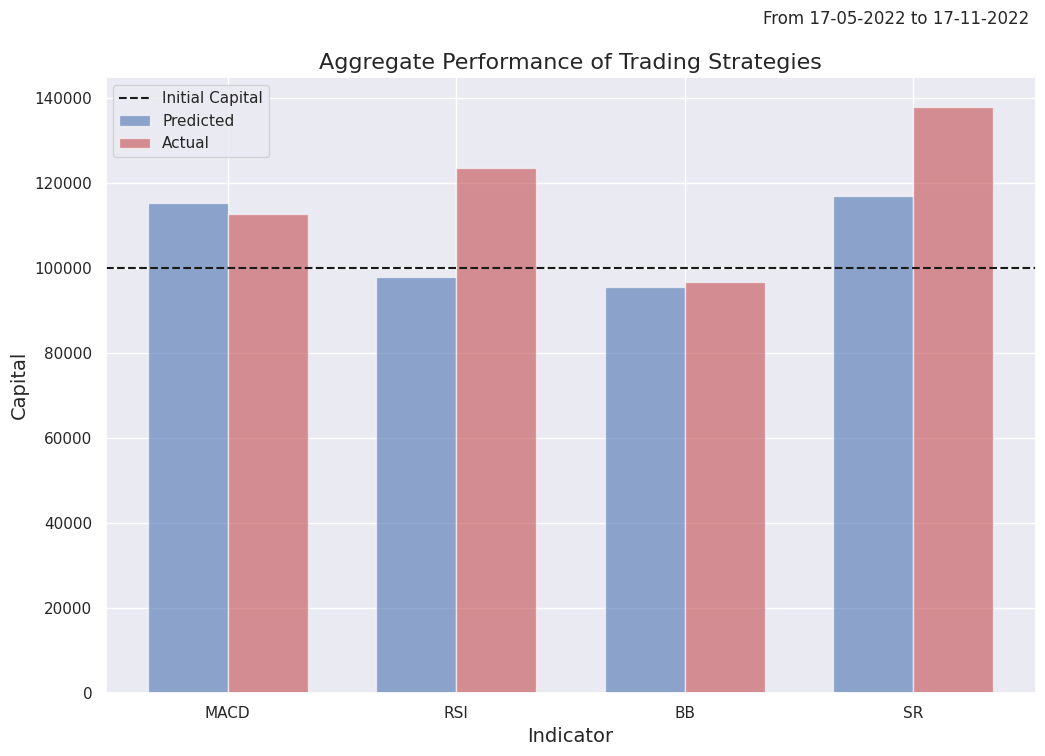

In [782]:
from datetime import datetime

final_capitals_pred = [
    capital_pred_macd,
    capital_pred_rsi,
    capital_pred_bb,
    capital_pred_sr
]

final_capitals_test = [
    capital_test_macd,
    capital_test_rsi,
    capital_test_bb,
    capital_test_sr
]

# Indicators
indicators = ['MACD', 'RSI', 'BB', 'SR']

# Creating the bar positions
n = len(indicators)
index = np.arange(n)
bar_width = 0.35

# Creating the plot
fig, ax = plt.subplots(figsize=(12, 8))

bar1 = ax.bar(index, final_capitals_pred, bar_width, label='Predicted', color='b', alpha=0.6)
bar2 = ax.bar(index + bar_width, final_capitals_test, bar_width, label='Actual', color='r', alpha=0.6)

# Adding initial capital line for reference
ax.axhline(y=initial_capital, color='k', linestyle='--', label='Initial Capital')

# Customizing the plot
ax.set_xlabel('Indicator', fontsize=14)
ax.set_ylabel('Capital', fontsize=14)
ax.set_title('Aggregate Performance of Trading Strategies', fontsize=16)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(indicators)
ax.legend()

# Adding text for labels, title and axes ticks
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(indicators)

# Adding the subtitle
original_format = '%Y-%m-%d'
start_date_dt = datetime.strptime(start_date, original_format)
end_date_dt = datetime.strptime(end_date, original_format)
date_range_text = f"From {start_date_dt.strftime('%d-%m-%Y')} to {end_date_dt.strftime('%d-%m-%Y')}"
# Position the text just below the title. Adjust y as needed.
ax.text(0.85, 1.08, date_range_text, transform=ax.transAxes, fontsize=12, ha='center', va='bottom')

plt.show()